In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.constants import h, hbar, c, eps0, a0, k_B

from LightMat import GaussianBeam, Lattice1d, BowtieLattice2d, LaserSetup, interactive_plot

In [2]:
i = 1.6 * u.mW/(u.cm**2)
w = 700 * u.um
P = i * np.pi * w**2 

P.to(u.mW)

<Quantity 0.02463009 mW>

In [3]:
def alpha_s12_hfs(lambda_, f, mf, epsilon=1): # epsilon=1 for linear polarization
    omega = (2*np.pi*c / lambda_).to(u.THz)
    # D values for K40
    gamma = 2*np.pi * 5.956 * u.MHz
    omegaD1 = 2*np.pi * 389.28618435 * u.THz
    omegaD2 = 2*np.pi * 391.01629605 * u.THz
    ispin = 4
    gf = (f * (f + 1) + 1 / 2 * (1 / 2 + 1) - ispin * (ispin + 1)) / (f * (f + 1))
    alpha = -(1/h * np.pi * c**2 * gamma * (1 / (2 * ((omegaD1 + omegaD2) / 2)**3))) * ((1 / (omega - omegaD1)) - (1/(omega + omegaD1)) \
            + (2 / (omega - omegaD2)) - (2 /(omega + omegaD1)) - gf * mf * np.sqrt(1 - epsilon**2) * ((1 / (omega - omegaD1)) - (1 / (omega + omegaD1)) \
            - 2 / (omega - omegaD2) + 2 / (omega + omegaD2)))
    return alpha.to(u.Hz/(u.mW/u.cm**2))

In [4]:
190*0.07

13.3

In [5]:
m_K40 = 39.96399848 * u.u # see Tiecke
alpha_S12_1064 = ((599.17 * 4*np.pi*eps0*a0**3 / h) / (2*eps0*c)).to(u.Hz/(u.mW/u.cm**2)) # see Savronova
alpha_S12_866 = ((1335.32 * 4*np.pi*eps0*a0**3 / h) / (2*eps0*c)).to(u.Hz/(u.mW/u.cm**2)) # see Savronova

lambda_rm = (c / ((c/(770.108385049*u.nm)).to(u.GHz)  - 50*u.GHz)).to(u.nm) # see Tiecke
alpha_rm1 = alpha_s12_hfs(lambda_rm, 9/2, -9/2) # see Tiecke
alpha_rm2 = alpha_s12_hfs(lambda_rm, 7/2, -7/2) # see Tiecke

k_1064 = 2*np.pi/(1064*u.nm) 
Er_1064 = (hbar**2 * k_1064**2 / (2*m_K40) / h).to(u.kHz)

k_866 = 2*np.pi/(866*u.nm)
Er_866 = (hbar**2 * k_866**2 / (2*m_K40) / h).to(u.kHz)

k_rm = 2*np.pi/lambda_rm
Er_rm = (hbar**2 * k_rm**2 / (2*m_K40) / h).to(u.kHz)

In [6]:
alpha_rm1

<Quantity 18.15656519 cm2 Hz / mW>

<h3>Horizontal lattice</h3>

In [7]:
w0 = 175 * u.um
lambda_ = 1064 * u.nm
P = 11 * u.W

bowtie = BowtieLattice2d(
    lattice_direction_vec1=(1,0,0),
    lattice_direction_vec2=(0,1,0),
    pol_Jones_vec='linear vertical', # linear vertical
    lambda_=lambda_,
    w0=w0,
    P=2*P,
    z0=0,
    name='2d Bowtie x-y',
)

lat1d_x = Lattice1d(
    lattice_direction_vec=(1,0,0),
    intersect_angle=0,
    pol_Jones_vec='linear horizontal', # linear horizontal
    lambda_=lambda_,
    w0=w0,
    P=P,
    z0=0,
    name='1D Lattice x',
)
lat1d_y = Lattice1d(
    lattice_direction_vec=(0,1,0),
    intersect_angle=0,
    pol_Jones_vec='linear horizontal', # linear horizontal
    lambda_=lambda_,
    w0=w0,
    P=P,
    z0=0,
    name='1D Lattice y',
)

pol_vec_3d             : [-0.-0.j         -0.-0.j         -0.-2.21178976j]
pol_vec_3d_alternative : [0.+0.j         0.+0.j         0.+1.95154174j]


pol_vec_3d             : [0.+0.j 1.+0.j 0.+0.j]
pol_vec_3d_alternative : [0.+0.j 1.+0.j 0.+0.j]


pol_vec_3d             : [1.+0.j 0.+0.j 0.+0.j]
pol_vec_3d_alternative : [1.+0.j 0.+0.j 0.+0.j]




<h3>Vertical shallow-angle lattice</h3>

In [8]:
w0_z = 50 * u.um
lambda_z = 866 * u.nm
P_z = 0.5 * u.W
angle = 165

lat1d_z = Lattice1d(   
    lattice_direction_vec=(0,0,1),
    intersect_angle=angle,
    intersect_axis=(-1,1,0),
    pol_Jones_vec='linear horizontal', # linear horizontal
    lambda_=lambda_z,
    w0=w0_z,
    P=P_z,
    z0=0,
    name='1D Shallow-angle Lattice z',
)

pol_vec_3d             : [-0.68921344-3.53960923e-17j  0.71310486+3.53960923e-17j
 -0.12837937+3.05899750e-05j]
pol_vec_3d_alternative : [-0.68921344-0.j          0.71310486-0.j         -0.05436285-0.15682969j]




<h3>Light sheet</h3>

In [9]:
w0_ls = [300, 10] * u.um
lambda_ls = 1064 * u.nm
P_ls = 3 * u.W

lightsheet = GaussianBeam(
    beam_direction_vec=(1,1,0),
    pol_Jones_vec=(1,0), # linear horizontal
    lambda_=lambda_ls,
    w0=w0_ls,
    P=P_ls,
    z0=0,
    name='Light Sheet',
)

<h3>Raman beams</h3>

In [10]:
w0_rm = 700 * u.um
lambda_rm = (c / ((c/(770.108385049*u.nm)).to(u.GHz)  - 50*u.GHz)).to(u.nm) # see Tiecke
P_rm1 = 50 * u.mW
P_rm2 = 50 * u.mW


raman1 = GaussianBeam(
    beam_direction_vec=(1,0,-0.2),
    pol_Jones_vec=(1,0), # linear horizontal
    lambda_=lambda_rm,
    w0=w0_rm,
    P=P_rm1,
    z0=0,
    name='Raman 1',
)

raman2 = GaussianBeam(
    beam_direction_vec=(0,-1,-0.2),
    pol_Jones_vec=(1,0), # linear horizontal
    lambda_=lambda_rm,
    w0=w0_rm,
    P=P_rm2,
    z0=0,
    name='Raman 2',
)

In [11]:
k_raman_vec = np.sqrt(raman1.k_vec**2 + raman2.k_vec**2)

In [15]:
k_raman_vec[2]

<Quantity 2.26256235 1 / um>

In [17]:
a = k_raman_vec[0] + k_raman_vec[1] +k_raman_vec[2]

52.89 / (a / k_raman_vec[2])

<Quantity 6.55303626>

In [11]:
lat1d_x.E_vec(1,1,1)

<Quantity [     0.       +0.j, 771514.7498787+0.j,      0.       +0.j] V / m>

In [12]:
lat1d_y.E_vec(1,1,1)

<Quantity [771514.7498787+0.j,      0.       +0.j,      0.       +0.j] V / m>

In [13]:
bowtie.E_vec(1,1,1)

<Quantity [0.+0.j, 0.+0.j, 0.+0.j] V / m>

<h3>Laser Setup</h3>

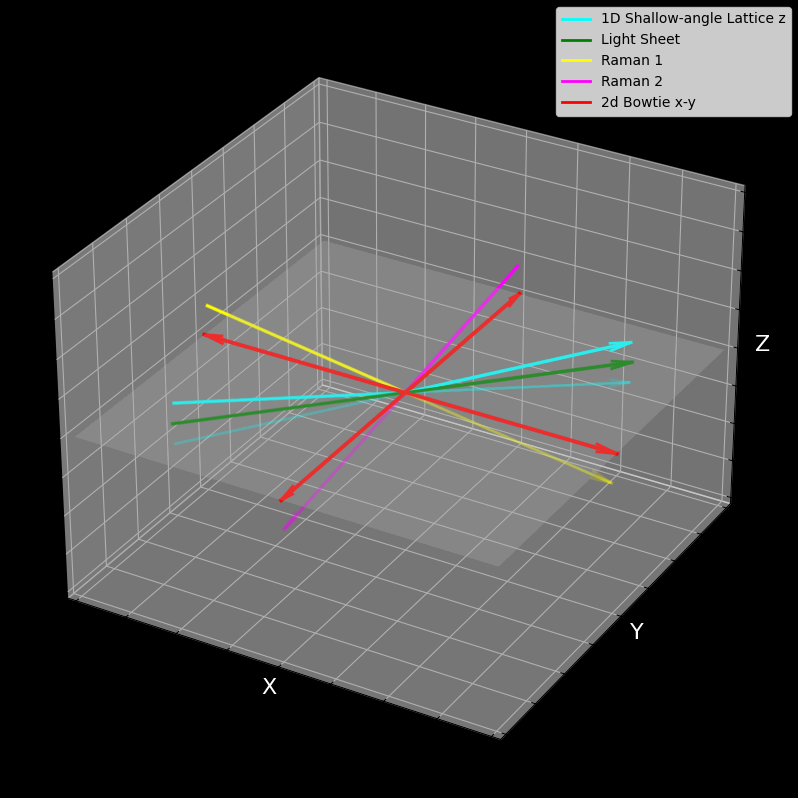

<Figure size 640x480 with 0 Axes>

In [14]:
lasers = [lat1d_z, lightsheet, raman1, raman2, bowtie, ]
lat3d = LaserSetup(lasers)

lat3d.plot_beams()
plt.savefig('laser_setup_bowtie.png', dpi=300, bbox_inches='tight')

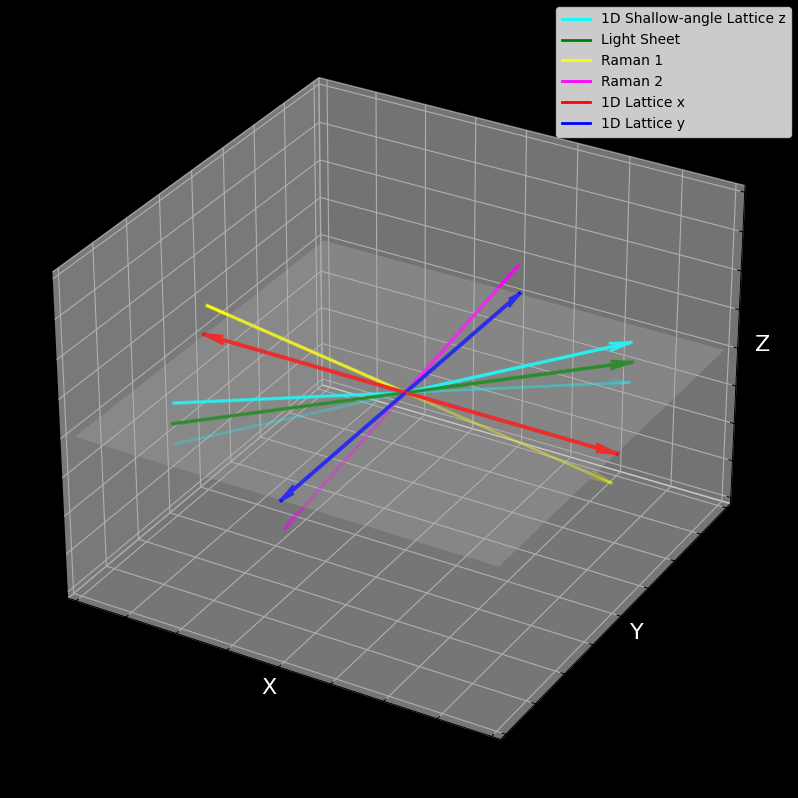

<Figure size 640x480 with 0 Axes>

In [15]:
lasers = [lat1d_z, lightsheet, raman1, raman2, lat1d_x, lat1d_y]
lat3d_reg = LaserSetup(lasers)

lat3d_reg.plot_beams()
plt.savefig('laser_setup_regular.png', dpi=300, bbox_inches='tight')

<h3>Lattice analysis</h3>

In [16]:
n = 151

x = np.linspace(-1, 1, n) * u.um
y = np.linspace(-1, 1, n) * u.um
z = np.linspace(-5, 5, n) * u.um

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

In [17]:
#lat2d_regular = LaserSetup([lat1d_x, lat1d_y])

V_bowtie_2d = - (alpha_S12_1064 * bowtie.I(X, Y, Z)).to(u.kHz) 
V_regular_2d = - (alpha_S12_1064 * lat1d_x.I(X, Y, Z)).to(u.kHz) - (alpha_S12_1064 * lat1d_y.I(X, Y, Z)).to(u.kHz)

V_light_sheet = - (alpha_S12_1064 * lightsheet.I(X, Y, Z)).to(u.kHz)
V_shallow_angle = - (alpha_S12_866 * lat1d_z.I(X, Y, Z)).to(u.kHz)

V_raman1 = - (alpha_rm1 * (raman1.I(X, Y, Z))).to(u.kHz)
V_raman2 = - (alpha_rm2 * (raman2.I(X, Y, Z))).to(u.kHz)

In [18]:
V_total_bowtie = V_bowtie_2d+V_shallow_angle+V_light_sheet+V_raman1+V_raman2
V_total_regular = V_regular_2d+V_shallow_angle+V_light_sheet+V_raman1+V_raman2

In [19]:
interactive_plot(
    [V_total_bowtie, V_total_regular],
    x, y, z,
    title = ['Total potential (bowtie)', 'Total potential (regular)'],
    cbar_title='V [h x kHz]',
)

Output()

In [20]:
# Define HO function
def V_HO(r, wx, wy, wz):
    x = r[0]
    y = r[1]
    z = r[2]
    m = m_K40.to(u.kg).value
    Vx = 0.5 * m_K40 * wx**2 * x**2
    Vy = 0.5 * m_K40 * wy**2 * y**2
    Vz = 0.5 * m_K40 * wz**2 * z**2
    return Vx + Vy + Vz

In [21]:
# Fit the curve
#initial_guess = [200, 200, 200] # in kHz
#R = [X.to(u.um).value, Y.to(u.um).value, Z.to(u.um).value]

In [22]:
#popt_bowtie, _ = curve_fit(V_HO, R, V_total_bowtie.to(u.kHz).value, p0=initial_guess)
#wx_bowtie, wy_bowtie, wz_bowtie = popt_bowtie
#
#popt_regular, _ = curve_fit(V_HO, R, V_total_regular.to(u.kHz).value, p0=initial_guess)
#wx_regular, wy_regular, wz_regular = popt_regular

In [23]:
d2V_bowtie_d2x = np.gradient(np.gradient(V_bowtie_2d+V_raman1+V_raman2, x, axis=0), x, axis=0)
d2V_bowtie_d2y = np.gradient(np.gradient(V_bowtie_2d+V_raman1+V_raman2, y, axis=1), y, axis=1)
d2V_bowtie_d2z = np.gradient(np.gradient(V_bowtie_2d+V_raman1+V_raman2, z, axis=2), z, axis=2)

d2V_regular_d2x = np.gradient(np.gradient(V_regular_2d+V_raman1+V_raman2, x, axis=0), x, axis=0)
d2V_regular_d2y = np.gradient(np.gradient(V_regular_2d+V_raman1+V_raman2, y, axis=1), y, axis=1)
d2V_regular_d2z = np.gradient(np.gradient(V_regular_2d+V_raman1+V_raman2, z, axis=2), z, axis=2)

d2V_shallow_angle_d2x = np.gradient(np.gradient(V_shallow_angle+V_raman1+V_raman2, x, axis=0), x, axis=0)
d2V_light_sheet_d2x = np.gradient(np.gradient(V_light_sheet+V_raman1+V_raman2, x, axis=0), x, axis=0)
d2V_shallow_angle_d2z = np.gradient(np.gradient(V_shallow_angle+V_raman1+V_raman2, z, axis=2), z, axis=2)
d2V_light_sheet_d2z = np.gradient(np.gradient(V_light_sheet+V_raman1+V_raman2, z, axis=2), z, axis=2)
d2V_both_d2z = np.gradient(np.gradient(V_shallow_angle+V_light_sheet+V_raman1+V_raman2, z, axis=2), z, axis=2)

d2V_raman_d2x = np.gradient(np.gradient(V_raman1 + V_raman2, x, axis=0), x, axis=0)
d2V_raman_d2y = np.gradient(np.gradient(V_raman1 + V_raman2, y, axis=1), y, axis=1)
d2V_raman_d2z = np.gradient(np.gradient(V_raman1 + V_raman2, z, axis=2), z, axis=2)

In [24]:
def get_lattice_depth(V, axis):
    return np.min(V.min(axis=axis))

def get_trap_frequency(d2V_d2xi):
    w_sq = ((h*d2V_d2xi).to(u.J/u.m**2) / m_K40).to(u.kHz**2)
    mask = w_sq.value > 0
    w = np.NaN * np.zeros_like(w_sq.value) * u.kHz 
    w[mask] = np.sqrt(w_sq[mask])
    return w

def get_lamb_dicke(w_trap, k_raman):
    a = np.sqrt(hbar/(2*m_K40*w_trap)).to(u.um)
    k_raman = k_raman.to(1/u.um)
    return k_raman*a

In [25]:
depth_xy_bowtie = get_lattice_depth(V_bowtie_2d, 0)
depth_xy_regular = get_lattice_depth(V_regular_2d, 0)
depth_x_raman = get_lattice_depth(V_raman1 + V_raman2, 0)
depth_y_raman = get_lattice_depth(V_raman1 + V_raman2, 1)

depth_z_shallow_angle = get_lattice_depth(V_shallow_angle, 2)
depth_z_light_sheet = get_lattice_depth(V_light_sheet, 2)
depth_z_both = get_lattice_depth(V_shallow_angle + V_light_sheet, 2)
depth_z_raman = get_lattice_depth(V_raman1 + V_raman2, 2)

w_xy_bowtie = get_trap_frequency(d2V_bowtie_d2x)
w_xy_regular = get_trap_frequency(d2V_regular_d2x)
w_x_raman = get_trap_frequency(d2V_raman_d2x)
w_y_raman = get_trap_frequency(d2V_raman_d2y)

w_z_shallow_angle = get_trap_frequency(d2V_shallow_angle_d2z)
w_z_light_sheet = get_trap_frequency(d2V_light_sheet_d2z)
w_z_both = get_trap_frequency(d2V_both_d2z)
w_z_raman = get_trap_frequency(d2V_raman_d2z)

k_raman_vec = np.sqrt(raman1.k_vec**2 + raman2.k_vec**2)

eta_xy_bowtie = get_lamb_dicke(np.nanmax(w_xy_bowtie), k_raman_vec[0])
eta_xy_regular = get_lamb_dicke(np.nanmax(w_xy_regular), k_raman_vec[0])
eta_x_raman = get_lamb_dicke(np.nanmax(w_x_raman), k_raman_vec[0])
eta_y_raman = get_lamb_dicke(np.nanmax(w_y_raman), k_raman_vec[1])

eta_z_shallow_angle = get_lamb_dicke(np.nanmax(w_z_shallow_angle), k_raman_vec[2])
eta_z_light_sheet = get_lamb_dicke(np.nanmax(w_z_light_sheet), k_raman_vec[2])
eta_z_both = get_lamb_dicke(np.nanmax(w_z_both), k_raman_vec[2])
eta_z_raman = get_lamb_dicke(np.nanmax(w_z_raman), k_raman_vec[2])

AxisError: axis 2 is out of bounds for array of dimension 0

In [ ]:
d2V_total_bowtie_d2x = np.gradient(np.gradient(V_total_bowtie, x, axis=0), x, axis=0)
d2V_total_bowtie_d2y = np.gradient(np.gradient(V_total_bowtie, y, axis=1), y, axis=1)
d2V_total_bowtie_d2z = np.gradient(np.gradient(V_total_bowtie, z, axis=2), z, axis=2)

d2V_total_regular_d2x = np.gradient(np.gradient(V_total_regular, x, axis=0), x, axis=0)
d2V_total_regular_d2y = np.gradient(np.gradient(V_total_regular, y, axis=1), y, axis=1)
d2V_total_regular_d2z = np.gradient(np.gradient(V_total_regular, z, axis=2), z, axis=2)

In [ ]:
depth_x_total_bowtie = np.max(V_total_bowtie[:, n//2, n//2]) - np.min(V_total_bowtie[:, n//2, n//2])
depth_y_total_bowtie = np.max(V_total_bowtie[n//2, :, n//2]) - np.min(V_total_bowtie[n//2, :, n//2])
depth_z_total_bowtie = np.max(V_total_bowtie[n//2, n//2, :]) - np.min(V_total_bowtie[n//2, n//2, :])

depth_x_total_regular = np.max(V_total_regular[:, n//2, n//2]) - np.min(V_total_regular[:, n//2, n//2])
depth_y_total_regular = np.max(V_total_regular[n//2, :, n//2]) - np.min(V_total_regular[n//2, :, n//2])
depth_z_total_regular = np.max(V_total_regular[n//2, n//2, :]) - np.min(V_total_regular[n//2, n//2, :])


w_x_total_bowtie = get_trap_frequency(d2V_total_bowtie_d2x)
w_y_total_bowtie = get_trap_frequency(d2V_total_bowtie_d2y)
w_z_total_bowtie = get_trap_frequency(d2V_total_bowtie_d2z)

w_x_total_regular = get_trap_frequency(d2V_total_regular_d2x)
w_y_total_regular = get_trap_frequency(d2V_total_regular_d2y)
w_z_total_regular = get_trap_frequency(d2V_total_regular_d2z)

k_raman_vec = np.sqrt(raman1.k_vec**2 + raman2.k_vec**2)

eta_x_total_bowtie = get_lamb_dicke(np.nanmax(w_x_total_bowtie), k_raman_vec[0])
eta_y_total_bowtie = get_lamb_dicke(np.nanmax(w_y_total_bowtie), k_raman_vec[1])
eta_z_total_bowtie = get_lamb_dicke(np.nanmax(w_z_total_bowtie), k_raman_vec[2])

eta_x_total_regular = get_lamb_dicke(np.nanmax(w_x_total_regular), k_raman_vec[0])
eta_y_total_regular = get_lamb_dicke(np.nanmax(w_y_total_regular), k_raman_vec[1])
eta_z_total_regular = get_lamb_dicke(np.nanmax(w_z_total_regular), k_raman_vec[2])


In [ ]:
depth_z_total_bowtie.to(u.kHz).value

3430.2418178850553

In [ ]:
data = {
    "Configuration": [
        "Bowtie x", 
        "Bowtie y",
        "Bowtie z", 
        "Regular x",
        "Regular y",
        "Regular z", 
    ],
    "Depth [h x kHz]": [
        depth_x_total_bowtie.to(u.kHz).value,
        depth_y_total_bowtie.to(u.kHz).value,
        depth_z_total_bowtie.to(u.kHz).value,
        depth_x_total_regular.to(u.kHz).value,
        depth_y_total_regular.to(u.kHz).value,
        depth_z_total_regular.to(u.kHz).value,
    ],
    "Depth [Er]": [
        depth_x_total_bowtie/Er_1064,
        depth_y_total_bowtie/Er_1064,
        depth_z_total_bowtie/Er_1064,
        depth_x_total_regular/Er_1064,
        depth_y_total_regular/Er_1064,
        depth_z_total_regular/Er_1064,
    ],
    "Depth [µK]": [
        (h*depth_x_total_bowtie/k_B).to(u.uK).value,
        (h*depth_y_total_bowtie/k_B).to(u.uK).value,
        (h*depth_z_total_bowtie/k_B).to(u.uK).value,
        (h*depth_x_total_regular/k_B).to(u.uK).value,
        (h*depth_y_total_regular/k_B).to(u.uK).value,
        (h*depth_z_total_regular/k_B).to(u.uK).value,
    ],
    "Trap frequency [kHz]": [
        f'2π x {np.nanmax(w_x_total_bowtie).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_y_total_bowtie).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_total_bowtie).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_x_total_regular).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_y_total_regular).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_total_regular).to(u.kHz).value / (2*np.pi)}',
    ],
    "Lamb Dicke parameter": [
        eta_x_total_bowtie,
        eta_y_total_bowtie,
        eta_z_total_bowtie,
        eta_x_total_regular,
        eta_y_total_regular,
        eta_z_total_regular,
    ],
}

df = pd.DataFrame(data)
df.style.set_properties(**{'text-align': 'left'})

,Configuration,Depth [h x kHz],Depth [Er],Depth [µK],Trap frequency [kHz],Lamb Dicke parameter
0,Bowtie x,5137.537313,1165.0115808796659,246.562904,2π x 424.62202804641834,0.1393943010932525
1,Bowtie y,5137.314965,1164.9611601548345,246.552233,2π x 424.62056951917003,0.1393945404954699
2,Bowtie z,3430.241818,777.8574050857292,164.625643,2π x 37.41954326319276,0.09391328528641363
3,Regular x,2569.036591,582.5665484739125,123.294311,2π x 211.98308882142356,0.1972857289415074
4,Regular y,2568.655239,582.4800713258098,123.276009,2π x 211.98016723930223,0.1972870884660327
5,Regular z,3430.241818,777.8574050857292,164.625643,2π x 37.412953313162184,0.09392155590597391


In [ ]:
V_total_bowtie = V_bowtie_2d + V_shallow_angle + V_light_sheet + V_raman1 + V_raman2

depth_total_bowtie = get_lattice_depth(V_total_bowtie, 0)
w_x_total_bowtie = get_trap_frequency(d2V_bowtie_d2x + d2V_shallow_angle_d2x + d2V_light_sheet_d2x + d2V_raman_d2x)
w_z_total_bowtie = get_trap_frequency(d2V_bowtie_d2z + d2V_shallow_angle_d2z + d2V_light_sheet_d2z + d2V_raman_d2z)

eta_x_total_bowtie = get_lamb_dicke(np.nanmax(w_x_total_bowtie), k_raman_vec[0])
eta_z_total_bowtie = get_lamb_dicke(np.nanmax(w_z_total_bowtie), k_raman_vec[2])

In [ ]:
raman1.k_vec

<Quantity [5.71159162, 5.71159162, 1.14231832] 1 / um>

In [ ]:
raman2.k_vec

<Quantity [ 5.71159162, -5.71159162,  1.14231832] 1 / um>

In [ ]:
data = {
    "Configuration": [
        "Bowtie", 
        "Regular", 
        "Shallow angle", 
        "Light sheet", 
        "Shallow angle + Light sheet",
        "Raman along x",
        "Raman along y",
        "Raman along z",
        "x",
        "z",
    ],
    "Depth [h x kHz]": [
        depth_xy_bowtie.to(u.kHz).value,
        depth_xy_regular.to(u.kHz).value,
        depth_z_shallow_angle.to(u.kHz).value,
        depth_z_light_sheet.to(u.kHz).value,
        depth_z_both.to(u.kHz).value,
        depth_x_raman.to(u.kHz).value,
        depth_y_raman.to(u.kHz).value,
        depth_z_raman.to(u.kHz).value,
        depth_total_bowtie.to(u.kHz).value,
        depth_total_bowtie.to(u.kHz).value,
    ],
    "Depth [Er]": [
        depth_xy_bowtie/Er_1064,
        depth_xy_regular/Er_1064,
        depth_z_shallow_angle/Er_866,
        depth_z_light_sheet/Er_1064,
        depth_z_shallow_angle/Er_866 + depth_z_light_sheet/Er_1064,
        depth_x_raman/Er_rm,
        depth_y_raman/Er_rm,
        depth_z_raman/Er_rm,
        depth_total_bowtie/Er_1064,
        depth_total_bowtie/Er_1064,
    ],
    "Depth [µK]": [
        (h*depth_xy_bowtie/k_B).to(u.uK).value,
        (h*depth_xy_regular/k_B).to(u.uK).value,
        (h*depth_z_shallow_angle/k_B).to(u.uK).value,
        (h*depth_z_light_sheet/k_B).to(u.uK).value,
        (h*depth_z_both/k_B).to(u.uK).value,
        (h*depth_x_raman/k_B).to(u.uK).value,
        (h*depth_y_raman/k_B).to(u.uK).value,
        (h*depth_z_raman/k_B).to(u.uK).value,
        (h*depth_total_bowtie/k_B).to(u.uK).value,
        (h*depth_total_bowtie/k_B).to(u.uK).value,
    ],
    "Trap frequency [kHz]": [
        f'2π x {np.nanmax(w_xy_bowtie).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_xy_regular).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_shallow_angle).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_light_sheet).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_both).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_x_raman).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_y_raman).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_raman).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_x_total_bowtie).to(u.kHz).value / (2*np.pi)}',
        f'2π x {np.nanmax(w_z_total_bowtie).to(u.kHz).value / (2*np.pi)}',
    ],
    "Lamb Dicke parameter": [
        eta_xy_bowtie,
        eta_xy_regular,
        eta_z_shallow_angle,
        eta_z_light_sheet,
        eta_z_both,
        eta_x_raman,
        eta_y_raman,
        eta_z_raman,
        eta_x_total_bowtie,
        eta_z_total_bowtie,
    ],
}

df = pd.DataFrame(data)
df.style.set_properties(**{'text-align': 'left'})

,Configuration,Depth [h x kHz],Depth [Er],Depth [µK],Trap frequency [kHz],Lamb Dicke parameter
0,Bowtie,-20549.182378,-4659.827070387048,-986.205212,2π x 424.6205322293306,0.13939454661622896
1,Regular,-5137.295594,-1164.9567675967621,-246.551303,2π x 211.98009254056822,0.19728712322659506
2,Shallow angle,-3133.279455,-470.6812655385494,-150.373697,2π x 37.29041076382752,0.0940757503318674
3,Light sheet,-893.936608,-202.71317507735054,-42.902191,2π x 3.007082557246192,0.3312863932802886
4,Shallow angle + Light sheet,-4027.216063,-673.3944406159,-193.275888,2π x 37.41145283140058,0.0939234393688971
5,Raman along x,-235.894457,-28.030123212079484,-11.321148,2π x 0.01575729484787556,22.88260416753413
6,Raman along y,-235.894457,-28.030123212079484,-11.321148,2π x 0.01575729484787556,22.88260416753413
7,Raman along z,-235.894457,-28.030123212079484,-11.321148,2π x 0.021851429947715658,3.8863001857993313
8,x,-24812.109767,-5626.508083965886,-1190.793459,2π x 424.6220289235225,0.13939430094928523
9,z,-24812.109767,-5626.508083965886,-1190.793459,2π x 37.419562403649905,0.0939132612676474


In [ ]:
interactive_plot(
    [w_xy_bowtie, w_xy_regular, w_z_shallow_angle, w_z_light_sheet, w_z_both], 
    x, y, z, 
    ['Bowtie', 'Regular', 'Shallow angle', 'Light sheet', 'Shallow angle + Light sheet'], 
    r'$\omega$ [hbar x kHz]',
)

Output()